In [51]:
from hatchet import *
import json
from state import State
from preprocess import PreProcess
import numpy as np
import utils
import random
import os
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.nonparametric.api as smnp

In [52]:
dirname = '/Users/jarus/ucd/Research/Visualisation/projects/CallFlow/.callflow'
# dirname = '/home/vidi/Work/llnl/CallFlow/.callflow'
dataset = 'calc-pi'

In [53]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format

# Read entire dataset

In [54]:
def replace_str_with_Node(df, graph):
        mapper = {}
        def dfs_recurse(root):
            for node in root.children: 
                mapper[node.callpath[-1]] = Node(node.nid, node.callpath, None)
                dfs_recurse(node)
        for root in graph.roots:
            mapper[root.callpath[-1]] = Node(root.nid, root.callpath, None)
            dfs_recurse(root)
        df['node'] = df['node'].apply(lambda node: mapper[node] if node in mapper else '')
        return df

In [55]:
def write_gf(state, state_name, format_of_df, write_graph=True):
    print('writing file for {0} format'.format(format_of_df))

    if write_graph:
        # dump the entire_graph as literal
        graph_literal = state.graph.to_literal(graph=state.graph, dataframe=state.df)
        graph_filepath = dirname + '/' + state_name + '/' + format_of_df + '_graph.json'
        print('File path: {0}'.format(graph_filepath))
        with open(graph_filepath, 'w') as graphFile:
            json.dump(graph_literal, graphFile)

    # dump the filtered dataframe to csv.
    df_filepath = dirname + '/' + state_name + '/' + format_of_df + '_df.csv'
    state.df.to_csv(df_filepath)

In [56]:
def read_gf(name):
    state = State()
    df_filepath = dirname + '/' + name +  '/filter_df.csv'
    entire_df_filepath = dirname + '/' + name + '/entire_df.csv'
    graph_filepath = dirname + '/' + name + '/filter_graph.json'
    entire_graph_filepath = dirname + '/' + name + '/entire_graph.json'   
    group_df_filepath = dirname + '/' + name + '/group_df.csv'

    with open(graph_filepath, 'r') as graphFile:
        data = json.load(graphFile)

    state.gf = GraphFrame()
    state.gf.from_literal_persist(data)

    with open(entire_graph_filepath, 'r') as entire_graphFile:
        entire_data = json.load(entire_graphFile)
            
    state.entire_gf = GraphFrame()
    state.entire_gf.from_literal_persist(entire_data)

    state.df = pd.read_csv(df_filepath)
    state.entire_df = pd.read_csv(entire_df_filepath)

    state.graph = state.gf.graph
    state.entire_graph = state.entire_gf.graph

    # replace df['node'] from str to the Node object.
    state.df = replace_str_with_Node(state.df, state.graph)
    state.entire_df = replace_str_with_Node(state.entire_df, state.entire_graph)
    
    state.group_df = pd.read_csv(group_df_filepath)

    return state

In [57]:
##############################################################################
# Copyright (c) 2018-2019, Lawrence Livermore National Security, LLC.
# Produced at the Lawrence Livermore National Laboratory.
#
# This file is part of Callflow.
# Created by Suraj Kesavan <kesavan1@llnl.gov>.
# LLNL-CODE-741008. All rights reserved.
#
# For details, see: https://github.com/LLNL/Callflow
# Please also read the LICENSE file for the MIT License notice.
##############################################################################

#!/usr/bin/env python3

import pandas as pd
import time 
import utils
from logger import log

class Filter:
    '''
    Filter the graphframe.
    Input: State object, parameter to filterBy (could be inclusive/exclusive, 
            filterPerc: user provided filter percentage (1-100))
    '''
    def __init__(self, state, filterBy, filterPerc):
        utils.debug('filter By:', filterBy)
        utils.debug('filter Perc:', filterPerc)
        self.state = state
        self.graph = state.entire_graph
        self.df = state.entire_df
        self.gf = state.entire_gf

        self.df.set_index(['node', 'rank'], drop=False, inplace=True)

        # self.df = pd.MultiIndex.from_frame(self.df, names=['node', 'rank'])
        self.gf.dataframe = self.df
        
        self.filterBy = filterBy
        self.filterPercInDecimals = int(filterPerc)/100
        # self.filterPercInDecimals = 0.001 
        
        self.fgf = self.run() 
        self.fgf = self.graft()

        # update df and graph after filtering.
        self.df = self.fgf.dataframe
        self.graph = self.fgf.graph

    def run(self):
        log.info('Filtering the graph.')
        t = time.time()
        if self.filterBy == "Inclusive":
            max_inclusive_time = utils.getMaxIncTime_from_gf(self.graph, self.df)
            filter_gf = self.gf.filter(lambda x: True if(x['time (inc)'] > self.filterPercInDecimals*max_inclusive_time) else False)
        elif filterBy == "Exclusive":
            max_exclusive_time = utils.getMaxExcTime_from_gf(self.graph, self.df)
            log.info('[Filter] By Exclusive time = {0})'.format(max_exclusive_time))
            filter_gf = self.gf.filter(lambda x: True if (x['time'] >= self.filterPercInDecimals*max_exclusive_time) else False)
        else:
            log.warn("Not filtering.... Can take forever. Thou were warned")
            filter_gf = self.gf
        
        log.info('[Filter] Removed {0} rows. (time={1})'.format(self.gf.dataframe.shape[0] - filter_gf.dataframe.shape[0], time.time() - t))

        return filter_gf

    def graft(self):
        log.info("Squashing the graph.")
        t = time.time()
        fgf = self.fgf.squash()
        log.info("[Squash] {1} rows in dataframe (time={0})".format(time.time() - t, fgf.dataframe.shape[0]))
        return fgf

In [58]:
def ffilter(state, filterBy, filterPerc):
        filter_obj = Filter(state, filterBy, filterPerc)

        state.gf = filter_obj.gf
        state.df = filter_obj.df
        state.graph = filter_obj.graph

        return state

In [59]:
state = read_gf(dataset)

In [60]:
print(state.df)

                   node  rank   time (inc)       time  nid  rank.1  \
0        <program root>     0   999,238.00       0.00    2       0   
1        <program root>     1   999,390.00       0.00    2       1   
2        <program root>     2 1,000,306.00       0.00    2       2   
3        <program root>     3   999,308.00       0.00    2       3   
4                  main     0   999,238.00       0.00    4       0   
..                  ...   ...          ...        ...  ...     ...   
63  <unknown procedure>     3   173,876.00       0.00   54       3   
64     <unknown file>:0     0   197,718.00 197,718.00   55       0   
65     <unknown file>:0     1   244,939.00 244,939.00   55       1   
66     <unknown file>:0     2   221,846.00 221,846.00   55       2   
67     <unknown file>:0     3   173,876.00 173,876.00   55       3   

                   name type            file  line                     module  \
0        <program root>   PF  <unknown file>     0        libmonitor.so.0.0.0 

# Half-calc-pi dataset

In [61]:
def setvalues(state):
    random = pd.Series(np.random.rand(state.df.shape[0]))
    print(random)
    state.df['time (inc)'] = state.df['time (inc)']*random
    state.df['time'] = state.df['time']*random
    state.entire_df['time (inc)'] = state.entire_df['time (inc)']*random
    state.entire_df['time'] = state.entire_df['time']*random
    state.group_df['time (inc)'] = state.group_df['time (inc)']*random
    return state

In [62]:
def create_dot_callflow_folder(dataset):
            dataset_dir = dirname + '/' + dataset
            if not os.path.exists(dataset_dir):
                utils.debug('Creating .callflow directory for dataset : {0}'.format(dataset))
                os.makedirs(dataset_dir)
    
            files = ["entire_df.csv", "filter_df.csv", "entire_graph.json", "filter_graph.json", "group_df.csv"]
            for f in files:
                if not os.path.exists(dataset_dir + '/' + f):
                    open(os.path.join(dataset_dir, f), 'w').close()

In [63]:
def create_n_runs(incoming_dataset, n, filterBy, filterPerc):
    states = {}
    for i in range(0, n):
        print("Reading dataset: ", incoming_dataset)
        state = read_gf(incoming_dataset)
        dataset = incoming_dataset + '-random-' + str(i)
        create_dot_callflow_folder(dataset)
        state = setvalues(state)
        states[dataset] = state
        write_gf(state, dataset, 'entire')
        print("Writing to entire dataset: ", dataset)
        state = ffilter(state, filterBy, filterPerc) 
        print("Writing to filter dataset: ", dataset)
        write_gf(state, dataset, 'filter')
        df_filepath = dirname + '/' + dataset + '/' +'group_df.csv'
        state.group_df.to_csv(df_filepath)
    return states

In [64]:
states = create_n_runs('calc-pi', 10, 'Inclusive', 1)

Reading dataset:  calc-pi
0    0.75
1    0.60
2    0.79
3    0.19
4    0.01
     ... 
63   0.51
64   0.79
65   0.38
66   0.23
67   0.84
Length: 68, dtype: float64
writing file for entire format
DFS on the graph
Root = <program root> [2]
Node = main[Module = cpi:4] time (inc) = 401448.7846991974 time = 0.0
- Node = 62:MPI_Finalize[Module = libmonitor.so.0.0.0:27] time (inc) = 577081.9194025205 time = 0.0
- - Node = PMPI_Finalize[Module = libmpi.so.12.0.5:29] time (inc) = 452070.1900724712 time = 0.0
- - - Node = 294:MPID_Finalize[Module = libmpi.so.12.0.5:31] time (inc) = 420635.80337181466 time = 0.0
- - - - Node = 162:MPIDI_CH3_Finalize[Module = libmpi.so.12.0.5:33] time (inc) = 507079.91698034236 time = 0.0
- - - - - Node = 230:psm_dofinalize[Module = libmpi.so.12.0.5:35] time (inc) = 389056.1437486097 time = 0.0
- - - - - - Node = 36:<unknown procedure>[Module = libpsm_infinipath.so.1.14:37] time (inc) = 470168.7627759498 time = 0.0
- - - - - - - Node = <unknown procedure>[Module = 

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.05919790267944336)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.06608915328979492)


 43
                   node  rank  time (inc)  time  nid  rank.1  \
40  <unknown procedure>     0   97,909.60  0.00   43       0   
41  <unknown procedure>     1  178,691.14  0.00   43       1   
42  <unknown procedure>     2  162,868.48  0.00   43       2   
43  <unknown procedure>     3   57,806.12  0.00   43       3   

                   name type            file  line                     module  \
40  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
41  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
42  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
43  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   

                 node.1  n_index  mod_index  \
40  <unknown procedure>       21          2   
41  <unknown procedure>       21          2   
42  <unknown procedure>       21          2   
43  <unknown procedure>       21          2   

                                 

Writing to filter dataset:  calc-pi-random-0
writing file for filter format
DFS on the graph
Root = <program root> [2]
Node = main[Module = cpi:4] time (inc) = 401448.7846991974 time = 0.0
- Node = 62:MPI_Finalize[Module = libmonitor.so.0.0.0:27] time (inc) = 425764.34363186953 time = 0.0
- - Node = PMPI_Finalize[Module = libmpi.so.12.0.5:29] time (inc) = 582121.1804938525 time = 0.0
- - - Node = 294:MPID_Finalize[Module = libmpi.so.12.0.5:31] time (inc) = 313393.2380964071 time = 0.0
- - - - Node = 162:MPIDI_CH3_Finalize[Module = libmpi.so.12.0.5:33] time (inc) = 559680.8206718923 time = 0.0
Number of nodes in graph 6
Dataframe Information
Size: (24, 19)
Number of nodes in dataframe:  6
Nodes: dict_keys([('162:MPIDI_CH3_Finalize', 33), ('294:MPID_Finalize', 31), ('62:MPI_Finalize', 27), ('<program root>', 2), ('PMPI_Finalize', 29), ('main', 4)])
<program root> 2
                               node  rank  time (inc)  time  nid  rank.1  \
node           rank                             

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.04938316345214844)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.04607701301574707)


 37
                      node  rank  time (inc)  time  nid  rank.1  \
28  36:<unknown procedure>     0  107,785.76  0.00   37       0   
29  36:<unknown procedure>     1  159,826.40  0.00   37       1   
30  36:<unknown procedure>     2  112,329.99  0.00   37       2   
31  36:<unknown procedure>     3  198,813.62  0.00   37       3   

                      name type            file  line  \
28  36:<unknown procedure>   PF  <unknown file>     0   
29  36:<unknown procedure>   PF  <unknown file>     0   
30  36:<unknown procedure>   PF  <unknown file>     0   
31  36:<unknown procedure>   PF  <unknown file>     0   

                       module                  node.1  n_index  mod_index  \
28  libpsm_infinipath.so.1.14  36:<unknown procedure>       18          2   
29  libpsm_infinipath.so.1.14  36:<unknown procedure>       18          2   
30  libpsm_infinipath.so.1.14  36:<unknown procedure>       18          2   
31  libpsm_infinipath.so.1.14  36:<unknown procedure>       18    

Writing to filter dataset:  calc-pi-random-1
writing file for filter format
DFS on the graph
Root = <program root> [2]
Node = main[Module = cpi:4] time (inc) = 393068.716335744 time = 0.0
- Node = 62:MPI_Finalize[Module = libmonitor.so.0.0.0:27] time (inc) = 493233.82851200935 time = 0.0
- - Node = PMPI_Finalize[Module = libmpi.so.12.0.5:29] time (inc) = 313158.09624372824 time = 0.0
- - - Node = 294:MPID_Finalize[Module = libmpi.so.12.0.5:31] time (inc) = 547312.9537419295 time = 0.0
- - - - Node = 162:MPIDI_CH3_Finalize[Module = libmpi.so.12.0.5:33] time (inc) = 458686.8791103813 time = 0.0
Number of nodes in graph 6
Dataframe Information
Size: (24, 19)
Number of nodes in dataframe:  6
Nodes: dict_keys([('162:MPIDI_CH3_Finalize', 33), ('294:MPID_Finalize', 31), ('62:MPI_Finalize', 27), ('<program root>', 2), ('PMPI_Finalize', 29), ('main', 4)])
<program root> 2
                               node  rank  time (inc)  time  nid  rank.1  \
node           rank                             

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.


294:MPID_Finalize 31
                 node  rank  time (inc)  time  nid  rank.1               name  \
16  294:MPID_Finalize     0  458,097.01  0.00   31       0  294:MPID_Finalize   
17  294:MPID_Finalize     1  826,492.96  0.00   31       1  294:MPID_Finalize   
18  294:MPID_Finalize     2  504,991.09  0.00   31       2  294:MPID_Finalize   
19  294:MPID_Finalize     3  485,215.46  0.00   31       3  294:MPID_Finalize   

   type                                               file  line  \
16   PF  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...   162   
17   PF  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...   162   
18   PF  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...   162   
19   PF  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...   162   

              module             node.1  n_index  mod_index  \
16  libmpi.so.12.0.5  294:MPID_Finalize       15          3   
17  libmpi.so.12.0.5  294:MPID_Finalize       15          3   
18  libmpi.so.12.0.5  294:MPID_Finalize    

 CallFlow:  [Filter] Removed 112 rows. (time=0.03599405288696289)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.06476187705993652)


['162:MPIDI_CH3_Finalize', '294:MPID_Finalize', '62:MPI_Finalize', '<program root>', 'PMPI_Finalize', 'main'] {33, 2, 4, 27, 29, 31}
Writing to filter dataset:  calc-pi-random-2
writing file for filter format
DFS on the graph
Root = <program root> [2]
Node = main[Module = cpi:4] time (inc) = 715565.8256086976 time = 0.0
- Node = 62:MPI_Finalize[Module = libmonitor.so.0.0.0:27] time (inc) = 558751.0236914514 time = 0.0
- - Node = PMPI_Finalize[Module = libmpi.so.12.0.5:29] time (inc) = 602717.3017117191 time = 0.0
- - - Node = 294:MPID_Finalize[Module = libmpi.so.12.0.5:31] time (inc) = 481708.015200549 time = 0.0
- - - - Node = 162:MPIDI_CH3_Finalize[Module = libmpi.so.12.0.5:33] time (inc) = 583114.2953755963 time = 0.0
Number of nodes in graph 6
Dataframe Information
Size: (24, 19)
Number of nodes in dataframe:  6
Nodes: dict_keys([('162:MPIDI_CH3_Finalize', 33), ('294:MPID_Finalize', 31), ('62:MPI_Finalize', 27), ('<program root>', 2), ('PMPI_Finalize', 29), ('main', 4)])
<program r

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1



- - - - - - - - - - - - Node = <unknown file>:0[Module = Unknown(NA):55] time (inc) = 59086.35121966308 time = 59086.35121966308
- - - - - - - - - - - Node = <unknown procedure>[Module = libpsm_infinipath.so.1.14:46] time (inc) = 212228.83127804036 time = 0.0
- - - - - - - - - - - - Node = <unknown file>:0[Module = Unknown(NA):47] time (inc) = 269378.2131993516 time = 269378.2131993516
Number of nodes in graph 17
Dataframe Information
Size: (68, 19)
Number of nodes in dataframe:  17
Nodes: dict_keys([('162:MPIDI_CH3_Finalize', 33), ('230:psm_dofinalize', 35), ('294:MPID_Finalize', 31), ('36:<unknown procedure>', 37), ('62:MPI_Finalize', 27), ('<program root>', 2), ('<unknown file>:0', 44), ('<unknown file>:0', 47), ('<unknown file>:0', 55), ('<unknown procedure>', 39), ('<unknown procedure>', 41), ('<unknown procedure>', 43), ('<unknown procedure>', 46), ('<unknown procedure>', 49), ('<unknown procedure>', 54), ('PMPI_Finalize', 29), ('main', 4)])
<program root> 2
             node  r

 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.04909992218017578)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.07500481605529785)


<program root>
                               node  rank  time (inc)  time  nid  rank.1  \
node           rank                                                        
<program root> 0     <program root>     0  683,434.47  0.00    2       0   
               1     <program root>     1  951,459.91  0.00    2       1   
               2     <program root>     2  207,396.40  0.00    2       2   
               3     <program root>     3  224,701.16  0.00    2       3   

                               name type            file  line  \
node           rank                                              
<program root> 0     <program root>   PF  <unknown file>     0   
               1     <program root>   PF  <unknown file>     0   
               2     <program root>   PF  <unknown file>     0   
               3     <program root>   PF  <unknown file>     0   

                                  module          node.1  n_index  mod_index  \
node           rank                                

0    0.55
1    0.10
2    0.37
3    0.59
4    0.22
     ... 
63   0.50
64   0.32
65   0.75
66   0.94
67   0.98
Length: 68, dtype: float64
writing file for entire format
DFS on the graph
Root = <program root> [2]
Node = main[Module = cpi:4] time (inc) = 601825.4638374638 time = 0.0
- Node = 62:MPI_Finalize[Module = libmonitor.so.0.0.0:27] time (inc) = 368968.9069739966 time = 0.0
- - Node = PMPI_Finalize[Module = libmpi.so.12.0.5:29] time (inc) = 599122.1667020142 time = 0.0
- - - Node = 294:MPID_Finalize[Module = libmpi.so.12.0.5:31] time (inc) = 356510.95066883264 time = 0.0
- - - - Node = 162:MPIDI_CH3_Finalize[Module = libmpi.so.12.0.5:33] time (inc) = 411540.4507660608 time = 0.0
- - - - - Node = 230:psm_dofinalize[Module = libmpi.so.12.0.5:35] time (inc) = 460597.78982447146 time = 0.0
- - - - - - Node = 36:<unknown procedure>[Module = libpsm_infinipath.so.1.14:37] time (inc) = 503514.1315195153 time = 0.0
- - - - - - - Node = <unknown procedure>[Module = libpsm_infinipath.so.1.14:

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.03138995170593262)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.06850790977478027)


                node  rank  time (inc)       time  nid  rank.1  \
56  <unknown file>:0     0   86,419.08  86,419.08   47       0   
57  <unknown file>:0     1  282,095.16 282,095.16   47       1   
58  <unknown file>:0     2  198,534.07 198,534.07   47       2   
59  <unknown file>:0     3  253,216.85 253,216.85   47       3   

                name type            file  line       module  \
56  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
57  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
58  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
59  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   

              node.1  n_index  mod_index callees  \
56  <unknown file>:0       24         -1      []   
57  <unknown file>:0       24         -1      []   
58  <unknown file>:0       24         -1      []   
59  <unknown file>:0       24         -1      []   

                                              callers  show_node  \
56  ['pthread_creat

                  3     (('<program root>', 'main', '62:MPI_Finalize',...   31
162:MPIDI_CH3_Finalize 33
                                               node  rank  time (inc)  time  \
node                   rank                                                   
162:MPIDI_CH3_Finalize 0     162:MPIDI_CH3_Finalize     0  319,127.17  0.00   
                       1     162:MPIDI_CH3_Finalize     1  753,611.06  0.00   
                       2     162:MPIDI_CH3_Finalize     2  944,691.46  0.00   
                       3     162:MPIDI_CH3_Finalize     3  981,086.56  0.00   

                             nid  rank.1                    name type  \
node                   rank                                             
162:MPIDI_CH3_Finalize 0      33       0  162:MPIDI_CH3_Finalize   PF   
                       1      33       1  162:MPIDI_CH3_Finalize   PF   
                       2      33       2  162:MPIDI_CH3_Finalize   PF   
                       3      33       3  162:MPIDI_CH3

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.02884697914123535)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.05485987663269043)


                   node  rank  time (inc)  time  nid  rank.1  \
44  <unknown procedure>     0  223,580.28  0.00   46       0   
45  <unknown procedure>     1   67,492.51  0.00   46       1   
46  <unknown procedure>     2  297,479.60  0.00   46       2   
47  <unknown procedure>     3  209,276.15  0.00   46       3   

                   name type            file  line                     module  \
44  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
45  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
46  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
47  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   

                 node.1  n_index  mod_index  \
44  <unknown procedure>       23          2   
45  <unknown procedure>       23          2   
46  <unknown procedure>       23          2   
47  <unknown procedure>       23          2   

                                     

Reading dataset:  calc-pi
0    0.29
1    0.73
2    0.73
3    0.87
4    0.17
     ... 
63   0.49
64   0.77
65   0.87
66   0.85
67   0.48
Length: 68, dtype: float64
writing file for entire format
DFS on the graph
Root = <program root> [2]
Node = main[Module = cpi:4] time (inc) = 380047.02953691204 time = 0.0
- Node = 62:MPI_Finalize[Module = libmonitor.so.0.0.0:27] time (inc) = 689000.6454771052 time = 0.0
- - Node = PMPI_Finalize[Module = libmpi.so.12.0.5:29] time (inc) = 499858.3868790275 time = 0.0
- - - Node = 294:MPID_Finalize[Module = libmpi.so.12.0.5:31] time (inc) = 474911.1431875436 time = 0.0
- - - - Node = 162:MPIDI_CH3_Finalize[Module = libmpi.so.12.0.5:33] time (inc) = 767992.5491143244 time = 0.0
- - - - - Node = 230:psm_dofinalize[Module = libmpi.so.12.0.5:35] time (inc) = 394544.46375773277 time = 0.0
- - - - - - Node = 36:<unknown procedure>[Module = libpsm_infinipath.so.1.14:37] time (inc) = 121984.87510096753 time = 0.0
- - - - - - - Node = <unknown procedure>[Module =

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 113 rows. (time=0.031829118728637695)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 23 rows in dataframe (time=0.07141923904418945)


 46
<unknown file>:0 47
                node  rank  time (inc)       time  nid  rank.1  \
56  <unknown file>:0     0    1,135.77   1,135.77   47       0   
57  <unknown file>:0     1  316,083.77 316,083.77   47       1   
58  <unknown file>:0     2  300,372.00 300,372.00   47       2   
59  <unknown file>:0     3   56,839.46  56,839.46   47       3   

                name type            file  line       module  \
56  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
57  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
58  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
59  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   

              node.1  n_index  mod_index callees  \
56  <unknown file>:0       24         -1      []   
57  <unknown file>:0       24         -1      []   
58  <unknown file>:0       24         -1      []   
59  <unknown file>:0       24         -1      []   

                                              callers  show_nod

294:MPID_Finalize 31
                                     node  rank  time (inc)  time  nid  \
node              rank                                                   
294:MPID_Finalize 0     294:MPID_Finalize     0  429,699.80  0.00   31   
                  1     294:MPID_Finalize     1  418,287.45  0.00   31   
                  2     294:MPID_Finalize     2  823,153.65  0.00   31   
                  3     294:MPID_Finalize     3  492,795.37  0.00   31   

                        rank.1               name type  \
node              rank                                   
294:MPID_Finalize 0          0  294:MPID_Finalize   PF   
                  1          1  294:MPID_Finalize   PF   
                  2          2  294:MPID_Finalize   PF   
                  3          3  294:MPID_Finalize   PF   

                                                                     file  \
node              rank                                                      
294:MPID_Finalize 0     /tmp/dp

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.04600381851196289)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.05449318885803223)


 49
<unknown procedure> 54
                   node  rank  time (inc)  time  nid  rank.1  \
60  <unknown procedure>     0  196,645.55  0.00   54       0   
61  <unknown procedure>     1   38,188.74  0.00   54       1   
62  <unknown procedure>     2   22,023.37  0.00   54       2   
63  <unknown procedure>     3  129,482.29  0.00   54       3   

                   name type            file  line                     module  \
60  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
61  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
62  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
63  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   

                 node.1  n_index  mod_index  \
60  <unknown procedure>       28          2   
61  <unknown procedure>       28          2   
62  <unknown procedure>       28          2   
63  <unknown procedure>       28          2   

          

PMPI_Finalize 29
                             node  rank  time (inc)  time  nid  rank.1  \
node          rank                                                       
PMPI_Finalize 0     PMPI_Finalize     0  664,021.65  0.00   29       0   
              1     PMPI_Finalize     1  113,872.77  0.00   29       1   
              2     PMPI_Finalize     2  330,562.12  0.00   29       2   
              3     PMPI_Finalize     3  831,375.10  0.00   29       3   

                             name type  \
node          rank                       
PMPI_Finalize 0     PMPI_Finalize   PF   
              1     PMPI_Finalize   PF   
              2     PMPI_Finalize   PF   
              3     PMPI_Finalize   PF   

                                                                 file  line  \
node          rank                                                            
PMPI_Finalize 0     /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...   294   
              1     /tmp/dpkg-mkdeb.gouoc49UG7/s

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.03069281578063965)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.055786848068237305)


 54
<unknown file>:0 55
                node  rank  time (inc)       time  nid  rank.1  \
64  <unknown file>:0     0  157,982.67 157,982.67   55       0   
65  <unknown file>:0     1  239,671.39 239,671.39   55       1   
66  <unknown file>:0     2   74,301.12  74,301.12   55       2   
67  <unknown file>:0     3  162,046.92 162,046.92   55       3   

                name type            file  line       module  \
64  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
65  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
66  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
67  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   

              node.1  n_index  mod_index callees  \
64  <unknown file>:0       29         -1      []   
65  <unknown file>:0       29         -1      []   
66  <unknown file>:0       29         -1      []   
67  <unknown file>:0       29         -1      []   

                                              callers  show_nod

0    0.31
1    0.79
2    0.65
3    0.28
4    0.67
     ... 
63   0.38
64   0.81
65   0.49
66   0.08
67   0.51
Length: 68, dtype: float64
writing file for entire format
DFS on the graph
Root = <program root> [2]
Node = main[Module = cpi:4] time (inc) = 614142.036880488 time = 0.0
- Node = 62:MPI_Finalize[Module = libmonitor.so.0.0.0:27] time (inc) = 332381.98269172345 time = 0.0
- - Node = PMPI_Finalize[Module = libmpi.so.12.0.5:29] time (inc) = 280659.31686666474 time = 0.0
- - - Node = 294:MPID_Finalize[Module = libmpi.so.12.0.5:31] time (inc) = 626486.5327673289 time = 0.0
- - - - Node = 162:MPIDI_CH3_Finalize[Module = libmpi.so.12.0.5:33] time (inc) = 521977.1196214768 time = 0.0
- - - - - Node = 230:psm_dofinalize[Module = libmpi.so.12.0.5:35] time (inc) = 590166.8686174739 time = 0.0
- - - - - - Node = 36:<unknown procedure>[Module = libpsm_infinipath.so.1.14:37] time (inc) = 489661.4863079639 time = 0.0
- - - - - - - Node = <unknown procedure>[Module = libpsm_infinipath.so.1.14:3

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.04018592834472656)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.061063289642333984)


 55
<unknown procedure> 46
                   node  rank  time (inc)  time  nid  rank.1  \
44  <unknown procedure>     0   96,786.97  0.00   46       0   
45  <unknown procedure>     1  307,193.12  0.00   46       1   
46  <unknown procedure>     2  199,248.65  0.00   46       2   
47  <unknown procedure>     3   22,610.23  0.00   46       3   

                   name type            file  line                     module  \
44  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
45  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
46  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
47  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   

                 node.1  n_index  mod_index  \
44  <unknown procedure>       23          2   
45  <unknown procedure>       23          2   
46  <unknown procedure>       23          2   
47  <unknown procedure>       23          2   

          

                       3     (('<program root>', 'main', '62:MPI_Finalize',...   33
File path: /Users/jarus/ucd/Research/Visualisation/projects/CallFlow/.callflow/calc-pi-random-9/filter_graph.json


In [65]:
def calculate_distributions(states):
    results = {}
    modules = states['calc-pi-random-0'].df['module'].unique()
    num_of_bins = {}
    kde_grid = {}
    for module in modules:
        dist = {}
        mean_dist = {}
        for idx, state in enumerate(states):
            time_inc_df = states[state].df.loc[states[state].df['module'] == module]['time (inc)'].tolist()
            dist[state] = time_inc_df
            mean_dist[state] = np.mean(time_inc_df)
        np_mean_dist = np.array(tuple(mean_dist.values()))
        num_of_bins[module] = _freedman_diaconis_bins(np_mean_dist)
        kde_grid[module] = kde(np_mean_dist)
        print(kde_grid[module][0])
        series = pd.DataFrame({ 'x':kde_grid[module][0], 'y': kde_grid[module][1] })
        print(series)
        ax = sns.lineplot(x="x", y="y", data=series)
        print(kde_grid)
        results[module] = {
            "dist": dist,
            "mean_dist": mean_dist, 
            "bins": num_of_bins,
            "kde_x": kde_grid[module][0],
            "kde_y": kde_grid[module][1]
        }
    return results

{'calc-pi-random-0': <state.State object at 0x1a1d6497b8>, 'calc-pi-random-1': <state.State object at 0x1a1d646748>, 'calc-pi-random-2': <state.State object at 0x1a1e131cf8>, 'calc-pi-random-3': <state.State object at 0x1a1e14d9b0>, 'calc-pi-random-4': <state.State object at 0x1a1e177748>, 'calc-pi-random-5': <state.State object at 0x1a1e01c358>, 'calc-pi-random-6': <state.State object at 0x1a1e035940>, 'calc-pi-random-7': <state.State object at 0x1a1dfe8320>, 'calc-pi-random-8': <state.State object at 0x1a1dfcf080>, 'calc-pi-random-9': <state.State object at 0x1a1e00d2e8>}
Data is  [504117.38480964 565834.04461582 591020.03244132 419375.05167148
 446472.86645966 560630.55174677 583238.89851706 538902.62119123
 431806.09153461 358572.70968848]
biwidth is:  50987.32964623807
Grid is:  (512,)
Y is:  (512,)
[205610.72074977 206664.28493887 207717.84912797 208771.41331707
 209824.97750617 210878.54169527 211932.10588437 212985.67007347
 214039.23426257 215092.79845167 216146.36264077 21719

{'libmonitor.so.0.0.0': (array([205610.72074977, 206664.28493887, 207717.84912797, 208771.41331707,
       209824.97750617, 210878.54169527, 211932.10588437, 212985.67007347,
       214039.23426257, 215092.79845167, 216146.36264077, 217199.92682987,
       218253.49101897, 219307.05520807, 220360.61939717, 221414.18358627,
       222467.74777537, 223521.31196447, 224574.87615357, 225628.44034267,
       226682.00453178, 227735.56872088, 228789.13290998, 229842.69709908,
       230896.26128818, 231949.82547728, 233003.38966638, 234056.95385548,
       235110.51804458, 236164.08223368, 237217.64642278, 238271.21061188,
       239324.77480098, 240378.33899008, 241431.90317918, 242485.46736828,
       243539.03155738, 244592.59574648, 245646.15993558, 246699.72412468,
       247753.28831378, 248806.85250288, 249860.41669198, 250913.98088108,
       251967.54507018, 253021.10925928, 254074.67344838, 255128.23763748,
       256181.80182658, 257235.36601568, 258288.93020478, 259342.49439388,


{'libmonitor.so.0.0.0': (array([205610.72074977, 206664.28493887, 207717.84912797, 208771.41331707,
       209824.97750617, 210878.54169527, 211932.10588437, 212985.67007347,
       214039.23426257, 215092.79845167, 216146.36264077, 217199.92682987,
       218253.49101897, 219307.05520807, 220360.61939717, 221414.18358627,
       222467.74777537, 223521.31196447, 224574.87615357, 225628.44034267,
       226682.00453178, 227735.56872088, 228789.13290998, 229842.69709908,
       230896.26128818, 231949.82547728, 233003.38966638, 234056.95385548,
       235110.51804458, 236164.08223368, 237217.64642278, 238271.21061188,
       239324.77480098, 240378.33899008, 241431.90317918, 242485.46736828,
       243539.03155738, 244592.59574648, 245646.15993558, 246699.72412468,
       247753.28831378, 248806.85250288, 249860.41669198, 250913.98088108,
       251967.54507018, 253021.10925928, 254074.67344838, 255128.23763748,
       256181.80182658, 257235.36601568, 258288.93020478, 259342.49439388,


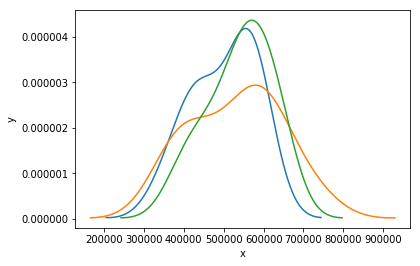

In [66]:
print(states)
results = calculate_distributions(states)
print(results)

{'dist': {'calc-pi-random-0': [748930.7559419839, 597987.5589946132, 789842.6257268087, 193120.7632862198, 313601.0765524997, 66435.91115203928, 749368.5891188504, 573651.7977040889], 'calc-pi-random-1': [987077.4489737961, 400813.14591350284, 329434.58816614194, 836411.8598251082, 97791.84531705697, 925666.5066120189, 701464.5257172978, 248012.43640166384], 'calc-pi-random-2': [714381.4294387047, 140948.57986833944, 986905.5258283649, 650920.6296293199, 347035.89263436233, 23576.257049462747, 953906.8365158408, 910485.1085661396], 'calc-pi-random-3': [683434.4709366525, 951459.9053879566, 207396.39809034893, 224701.15995685893, 493612.054940978, 337806.1939246241, 177738.4884165001, 278851.7417179272], 'calc-pi-random-4': [548666.8208929461, 104234.50077797327, 370192.11324673117, 592878.4748943449, 410327.02435570036, 132854.57598629748, 928537.4793905364, 484091.9421327405], 'calc-pi-random-5': [285072.16847527394, 739675.6969881323, 154721.57044023456, 711343.540338872, 874394.1521

TypeError: unsupported operand type(s) for /: 'dict' and 'int'

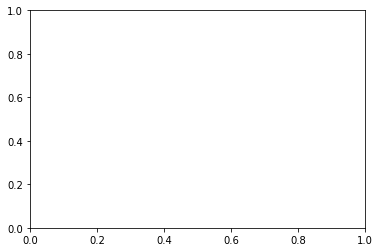

In [70]:
result = results['libmonitor.so.0.0.0']
print(result)
ax = sns.distplot(result, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

TypeError: unsupported operand type(s) for /: 'dict' and 'int'

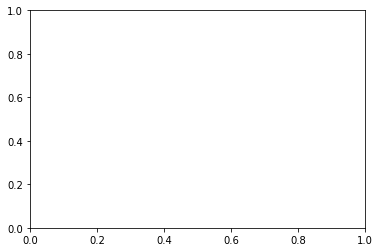

In [68]:
result = results['cpi']
ax = sns.distplot(result, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

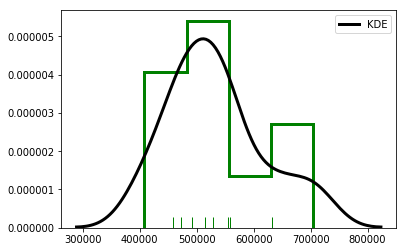

In [141]:
result = results['libmpi.so.12.0.5']
ax = sns.distplot(result, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

In [71]:
dataset = 'calc-pi-random-0'
state = read_gf(dataset)
print(state.df)

                      node  rank                  node.1  rank.1  time (inc)  \
0           <program root>     0          <program root>       0  748,930.76   
1           <program root>     1          <program root>       1  597,987.56   
2           <program root>     2          <program root>       2  789,842.63   
3           <program root>     3          <program root>       3  193,120.76   
4                     main     0                    main       0   12,224.42   
..                     ...   ...                     ...     ...         ...   
19       294:MPID_Finalize     3       294:MPID_Finalize       3  506,161.19   
20  162:MPIDI_CH3_Finalize     0  162:MPIDI_CH3_Finalize       0  791,054.19   
21  162:MPIDI_CH3_Finalize     1  162:MPIDI_CH3_Finalize       1  377,302.30   
22  162:MPIDI_CH3_Finalize     2  162:MPIDI_CH3_Finalize       2  227,880.12   
23  162:MPIDI_CH3_Finalize     3  162:MPIDI_CH3_Finalize       3  842,486.68   

    time  nid  rank.1.1                

AxesSubplot(0.125,0.125;0.775x0.755)


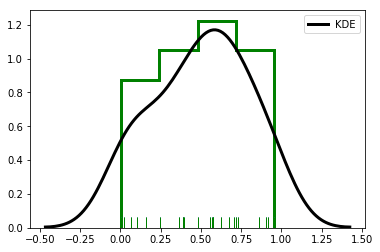

In [72]:
random = np.random.rand(state.df.shape[0])
ax = sns.distplot(random, hist=False, rug=True);
print(ax)

ax = sns.distplot(random, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

In [73]:
def iqr(a):
    """Calculate the IQR for an array of numbers."""
    a = np.asarray(a)
    q1 = stats.scoreatpercentile(a, 25)
    q3 = stats.scoreatpercentile(a, 75)
    return q3 - q1

In [74]:
def _freedman_diaconis_bins(a):
    """Calculate number of hist bins using Freedman-Diaconis rule."""
    # From https://stats.stackexchange.com/questions/798/
    a = np.asarray(a)
    if len(a) < 2:
        return 1
    h = 2 * iqr(a) / (len(a) ** (1 / 3))
    # fall back to sqrt(a) bins if iqr is 0
    if h == 0:
        return int(np.sqrt(a.size))
    else:
        return int(np.ceil((a.max() - a.min()) / h))

In [75]:
 def kde(data, gridsize=512, fft=True, kernel='gau', bw='scott', cut=3, clip=(-np.inf, np.inf)):
        print("Data is ", data)
        
        # assign binwidth using scott's factor
        if bw == 'scott':
            bw = stats.gaussian_kde(data).scotts_factor() * data.std(ddof=1)
        print("biwidth is: ", bw)    
        
        kde = smnp.KDEUnivariate(data)
        kde_gau = stats.gaussian_kde(data, bw_method=bw)
        
        # create the grid to fit the estimation.
        # clip = (0, data.max())
        # print(clip)
        support_min = max(data.min() - bw * cut, clip[0])
        support_max = min(data.max() + bw * cut, clip[1])
#         support_min = max(0, clip[0])
#         support_max = min(data.max(), clip[1])
        grid = np.linspace(support_min, support_max, gridsize)
        clip = (support_min, support_max)
        print("Grid is: ", grid.shape)
        
        kde.fit("gau", bw, fft, gridsize=gridsize, cut=cut, clip=clip)
        y = kde.density
        print("Y is: ", y.shape)
        x = grid
                
        return grid, y

In [76]:
def sshist(x, N=range(2, 501), SN=30):
    """
    Returns the optimal number of bins in a histogram used for density
    estimation.
    Optimization principle is to minimize expected L2 loss function between
    the histogram and an unknown underlying density function.
    An assumption made is merely that samples are drawn from the density
    independently each other.
    The optimal binwidth D* is obtained as a minimizer of the formula,
    (2K-V) / D^2,
    where K and V are mean and variance of sample counts across bins with width
    D. Optimal number of bins is given as (max(x) - min(x)) / D.
    Parameters
    ----------
    x : array_like
        One-dimensional data to fit histogram to.
    N : array_like, optional
        Array containing number of histogram bins to evaluate for fit.
        Default value = 500.
    SN : double, optional
        Scalar natural number defining number of bins for shift-averaging.
    Returns
    -------
    optN : int
        Optimal number of bins to represent the data in X
    N : double
        Maximum number of bins to be evaluated. Default value = 500.
    C : array_like
        Cost function C[i] of evaluating histogram fit with N[i] bins
    See Also
    --------
    sskernel, ssvkernel
    References
    ----------
    .. [1] H. Shimazaki and S. Shinomoto, "A method for selecting the bin size
           of a time histogram," in  Neural Computation 19(6), 1503-1527, 2007
           http://dx.doi.org/10.1162/neco.2007.19.6.1503
    """

    # determine range of input 'x'
    x_min = np.min(x)
    x_max = np.max(x)

    # get smallest difference 'dx' between all pairwise samples
    buf = np.abs(np.diff(np.sort(x)))
    dx = min(buf[buf > 0])

    # setup bins to evaluate
    N_MIN = 2
    N_MAX = min(np.floor((x_max - x_min) / (2*dx)), max(N))
    N_MAX = N_MAX.astype(int)  
    N = range(N_MIN, N_MAX+1)
    D = (x_max - x_min) / N

    # compute cost function over each possible number of bins
    Cs = np.zeros((len(N), SN))
    for i, n in enumerate(N):  # loop over number of bins
        shift = np.linspace(0, D[i], SN)
        for p, sh in enumerate(shift):  # loop over shift window positions

            # define bin edges
            edges = np.linspace(x_min + sh - D[i]/2,
                                x_max + sh - D[i]/2, N[i]+1)

            # count number of events in these bins
            ki = np.histogram(x, edges)

            # get mean and variance of events
            k = ki[0].mean()
            v = np.sum((ki[0] - k)**2) / N[i]

            Cs[i, p] = (2*k - v) / D[i]**2

    # average over shift window
    C = Cs.mean(axis=1)
    
    # get bin count that minimizes cost C
    idx = np.argmin(C)
    optN = N[idx]
    optD = D[idx]
    edges = np.linspace(x_min, x_max, optN)

    return optN, optD, edges, C, N

In [77]:
data = [999560.5, 522136.93900397, 505126.27075341, 714996.49335358, 565991.23472955]
sshist(data)

(2,
 247217.114623295,
 array([505126.27075341, 999560.5       ]),
 array([3.74968151e-11, 5.20864850e-11, 5.97222000e-11, 7.36301096e-11,
        8.71289631e-11, 1.07445419e-10, 1.31852437e-10, 1.48078332e-10,
        1.68394788e-10, 1.87620428e-10, 2.04937139e-10, 2.19526808e-10,
        2.34389182e-10]),
 range(2, 15))

In [78]:
def ssvkernel(x, tin=None, M=80, nbs=1e2, WinFunc='Boxcar'):
    """
    Generates a locally adaptive kernel-density estimate for one-dimensional
    data.
    The user provides a one-dimensional vector of samples drawn from some
    underlying unknown distribution, and optionally the values where they want
    to estimate the probability density of that distribution. The algorithm
    solves an optimization problem to identify variable bandwidths across the
    domain where the data is provided.
    The optimization is based on a principle of minimizing expected L2 loss
    function between the kernel estimate and an unknown underlying density
    function. An assumption is merely that samples are drawn from the density
    independently of each other.
    The locally adaptive bandwidth is obtained by iteratively computing optimal
    fixed-size bandwidths wihtihn local intervals. The optimal bandwidths are
    selected such that they are selected in the intervals that are gamma times
    larger than the optimal bandwidths themselves. The paramter gamma is
    optimized by minimizing the L2 risk estimate.
    Parameters
    ----------
    x : array_like
        The one-dimensional samples drawn from the underlying density
    tin : array_like, optional
        The values where the density estimate is to be evaluated in generating
        the output 'y'. Default value = None.
    M : int, optional
        The number of window sizes to evaluate. Default value = 80.
    nbs : int, optional
        The number of bootstrap samples to use in estimating the [0.05, 0.95]
        confidence interval of the output 'y'.
    WinFunc : string, optional
        The type of window function to use in estimating local bandwidth.
        Choose from one of 'Boxcar', 'Laplace', 'Cauchy' and 'Gauss'. Default
        value = 'Gauss'.
    Returns
    -------
    y : array_like
        The estimated density, evaluated at points t / tin.
    t : array_like
        The points where the density estimate 'y' is evaluated.
    optw : array_like
        The optimal local kernel bandwidths at 't'.
    gs : array_like
        The stiffness constants of the variables bandwidths evaluated.
    C : array_like
        Cost functions associated with stiffness constraints.
    confb95 : array_like
        The 5% and 95% confidence interval of the kernel density estimate 'y'.
        Has dimensions 2 x len(y). confb95[0,:] corresponds to the 5% interval,
        and confb95[1,:] corresponds to the 95% interval.
    yb : array_like
        The bootstrap samples used in estimating confb95. Each row corresponds
        to one bootstrap sample.
    See Also
    --------
    sshist, sskernel
    References
    ----------
    .. [1] H. Shimazaki and S. Shinomoto, "Kernel Bandwidth Optimization in 
           Spike Rate Estimation," in Journal of Computational Neuroscience 
           29(1-2): 171–182, 2010 http://dx.doi.org/10.1007/s10827-009-0180-4
    """

    # set argument 't' if not provided
    if tin is None:
        T = np.max(x) - np.min(x)
        dx = np.sort(np.diff(np.sort(x)))
        dt_samp = dx[np.nonzero(dx)][0]
        tin = np.linspace(np.min(x), np.max(x), min(np.ceil(T / dt_samp), 1e3))
        t = tin
        print(min(tin), max(tin),(x >= min(tin)) & (x <= max(tin)) )
#         x_ab = x[bool(x >= min(tin)) & (x <= max(tin))]
        x_ab = x
    else:
        T = np.max(x) - np.min(x)
        x_ab = x[(x >= min(tin)) & (x <= max(tin))]
        dx = np.sort(np.diff(np.sort(x)))
        dt_samp = dx[np.nonzero(dx)][0]
        if dt_samp > min(np.diff(tin)):
            t = np.linspace(min(tin), max(tin), min(np.ceil(T / dt_samp), 1e3))
        else:
            t = tin

    # calculate delta t
    dt = min(np.diff(t))

    # create the finest histogram
    thist = np.concatenate((t, (t[-1]+dt)[np.newaxis]))
    y_hist = np.histogram(x_ab, thist-dt/2)[0] / dt
    L = y_hist.size
    N = sum(y_hist * dt).astype(np.float)

    # initialize window sizes
    W = logexp(np.linspace(ilogexp(5 * dt), ilogexp(T), M))

    # compute local cost functions
    c = np.zeros((M, L))
    for j in range(M):
        w = W[j]
        yh = fftkernel(y_hist, w / dt)
        c[j, :] = yh**2 - 2 * yh * y_hist + 2 / (2 * np.pi)**0.5 / w * y_hist

    # initialize optimal ws
    optws = np.zeros((M, L))
    for i in range(M):
        Win = W[i]
        C_local = np.zeros((M, L))
        for j in range(M):
            C_local[j, :] = fftkernelWin(c[j, :], Win / dt, WinFunc)
        n = np.argmin(C_local, axis=0)
        optws[i, :] = W[n]

    # golden section search for stiffness parameter of variable bandwidths
    k = 0
    gs = np.zeros((30, 1))
    C = np.zeros((30, 1))
    tol = 1e-5
    a = 1e-12
    b = 1
    phi = (5**0.5 + 1) / 2
    c1 = (phi - 1) * a + (2 - phi) * b
    c2 = (2 - phi) * a + (phi - 1) * b
    f1 = CostFunction(y_hist, N, t, dt, optws, W, WinFunc, c1)[0]
    f2 = CostFunction(y_hist, N, t, dt, optws, W, WinFunc, c2)[0]
    while (np.abs(b-a) > tol * (abs(c1) + abs(c2))) & (k < 30):
        if f1 < f2:
            b = c2
            c2 = c1
            c1 = (phi - 1) * a + (2 - phi) * b
            f2 = f1
            f1, yv1, optwp1 = CostFunction(y_hist, N, t, dt, optws, W,
                                           WinFunc, c1)
            yopt = yv1 / np.sum(yv1 * dt)
            optw = optwp1
        else:
            a = c1
            c1 = c2
            c2 = (2 - phi) * a + (phi - 1) * b
            f1 = f2
            f2, yv2, optwp2 = CostFunction(y_hist, N, t, dt, optws, W,
                                           WinFunc, c2)
            yopt = yv2 / np.sum(yv2 * dt)
            optw = optwp2

        # capture estimates and increment iteration counter
        gs[k] = c1
        C[k] = f1
        k = k + 1

    # discard unused entries in gs, C
    gs = gs[0:k]
    C = C[0:k]

    # estimate confidence intervals by bootstrapping
    nbs = np.asarray(int(nbs))
    print(nbs)
    yb = np.zeros((nbs, tin.size))
    print(yb)
    for idx in range(nbs):
        Nb = np.random.poisson(lam=N)
        idx = np.random.randint(0, N, Nb)
        xb = x_ab[idx]
        thist = np.concatenate((t, (t[-1]+dt)[np.newaxis]))
        y_histb = np.histogram(xb, thist - dt / 2)[0]
        idx = y_histb.nonzero()
        y_histb_nz = y_histb[idx]
        t_nz = t[idx]
        yb_buf = np.zeros((L, ))
        for k in range(L):
            yb_buf[k] = np.sum(y_histb_nz * Gauss(t[k] - t_nz, optw[k])) / Nb
        yb_buf = yb_buf / np.sum(yb_buf * dt)
        yb[i, :] = np.interp(tin, t, yb_buf)
    ybsort = np.sort(yb, axis=0)
    y95b = ybsort[np.int(np.floor(0.05 * nbs)), :]
    y95u = ybsort[np.int(np.floor(0.95 * nbs)), :]
    confb95 = np.concatenate((y95b[np.newaxis], y95u[np.newaxis]), axis=0)

    # return outputs
    y = np.interp(tin, t, yopt)
    optw = np.interp(tin, t, optw)
    t = tin

    return y, t, optw, gs, C, confb95, yb


def CostFunction(y_hist, N, t, dt, optws, WIN, WinFunc, g):

    L = y_hist.size
    optwv = np.zeros((L, ))
    for k in range(L):
        gs = optws[:, k] / WIN
        if g > np.max(gs):
            optwv[k] = np.min(WIN)
        else:
            if g < min(gs):
                optwv[k] = np.max(WIN)
            else:
                idx = np.max(np.nonzero(gs >= g))
                optwv[k] = g * WIN[idx]

    # Nadaraya-Watson kernel regression
    optwp = np.zeros((L, ))
    for k in range(L):
        if WinFunc == 'Boxcar':
            Z = Boxcar(t[k]-t, optwv / g)
        elif WinFunc == 'Laplace':
            Z = Laplace(t[k]-t, optwv / g)
        elif WinFunc == 'Cauchy':
            Z = Cauchy(t[k]-t, optwv / g)
        else:  # WinFunc == 'Gauss'
            Z = Gauss(t[k]-t, optwv / g)
        optwp[k] = np.sum(optwv * Z) / np.sum(Z)

    # speed-optimized baloon estimator
    idx = y_hist.nonzero()
    y_hist_nz = y_hist[idx]
    t_nz = t[idx]
    yv = np.zeros((L, ))
    for k in range(L):
        yv[k] = np.sum(y_hist_nz * dt * Gauss(t[k]-t_nz, optwp[k]))
    yv = yv * N / np.sum(yv * dt)

    # cost function of estimated kernel
    cg = yv**2 - 2 * yv * y_hist + 2 / (2 * np.pi)**0.5 / optwp * y_hist
    Cg = np.sum(cg * dt)

    return Cg, yv, optwp


def fftkernel(x, w):
    # forward padded transform
    L = x.size
    Lmax = L + 3 * w
    n = 2 ** np.ceil(np.log2(Lmax))
    X = np.fft.fft(x, n.astype(np.int))

    # generate kernel domain
    f = np.linspace(0, n-1, n) / n
    f = np.concatenate((-f[0: np.int(n / 2 + 1)],
                        f[1: np.int(n / 2 - 1 + 1)][::-1]))

    # evaluate kernel
    K = np.exp(-0.5 * (w * 2 * np.pi * f) ** 2)

    # convolve and transform back from frequency domain
    y = np.real(np.fft.ifft(X * K, n))
    y = y[0:L]

    return y


def fftkernelWin(x, w, WinFunc):
    # forward padded transform
    L = x.size
    Lmax = L + 3 * w
    n = 2 ** np.ceil(np.log2(Lmax))
    X = np.fft.fft(x, n.astype(np.int))

    # generate kernel domain
    f = np.linspace(0, n-1, n) / n
    f = np.concatenate((-f[0: np.int(n / 2 + 1)],
                        f[1: np.int(n / 2 - 1 + 1)][::-1]))
    t = 2 * np.pi * f

    # determine window function - evaluate kernel
    if WinFunc == 'Boxcar':
        a = 12**0.5 * w
        K = 2 * np.sin(a * t / 2) / (a * t)
        K[0] = 1
    elif WinFunc == 'Laplace':
        K = 1 / (1 + (w * 2 * np.pi * f)**2 / 2)
    elif WinFunc == 'Cauchy':
        K = np.exp(-w * np.abs(2 * np.pi * f))
    else:  # WinFunc == 'Gauss'
        K = np.exp(-0.5 * (w * 2 * np.pi * f)**2)

    # convolve and transform back from frequency domain
    y = np.real(np.fft.ifft(X * K, n))
    y = y[0:L]

    return y


def Gauss(x, w):
    y = 1 / (2 * np.pi)**2 / w * np.exp(-x**2 / 2 / w**2)
    return y


def Laplace(x, w):
    y = 1 / 2**0.5 / w * np.exp(-(2**0.5) / w / np.abs(x))
    return y


def Cauchy(x, w):
    y = 1 / (np.pi * w * (1 + (x / w)**2))
    return y


def Boxcar(x, w):
    a = 12**0.5 * w
    y = 1 / a
    y[np.abs(x) > a / 2] = 0
    return y


def logexp(x):
    y = np.zeros(x.shape)
    y[x < 1e2] = np.log(1+np.exp(x[x < 1e2]))
    y[x >= 1e2] = x[x >= 1e2]
    return y


def ilogexp(x):
    y = np.zeros(x.shape)
    y[x < 1e2] = np.log(np.exp(x[x < 1e2]) - 1)
    y[x >= 1e2] = x[x >= 1e2]
    return y

In [79]:
ssvkernel(data)

/Users/jarus/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/jarus/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:238: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/jarus/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:260: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/jarus/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:268: RuntimeWarning: invalid value encountered in true_divide


505126.27075341 999560.5 [ True  True  True  True  True]
100
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


TypeError: only integer scalar arrays can be converted to a scalar index

[8.090054780582496e-06, 4.045027390291252e-06, 0.0, 0.0, 4.045027390291252e-06, 0.0, 0.0, 0.0, 0.0, 4.045027390291252e-06]
[8.090054780582496e-06, 4.045027390291252e-06, 0.0, 0.0, 4.045027390291252e-06, 0.0, 0.0, 0.0, 0.0, 4.045027390291252e-06] <class 'list'>
10 11 [8.09005478e-06 4.04502739e-06 0.00000000e+00 0.00000000e+00
 4.04502739e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.04502739e-06] [505126.27075341 554569.69367807 604013.11660273 653456.53952739
 702899.96245205 752343.3853767  801786.80830136 851230.23122602
 900673.65415068 950117.07707534 999560.5       ]


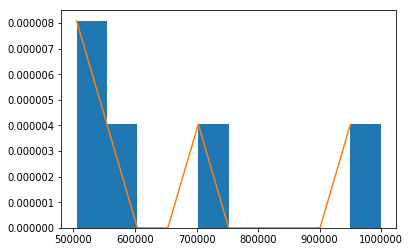

In [80]:
ser = 50*np.random.rand() * np.random.normal(10, 10, 100) + 20
ser = data
a = plt.hist(ser, normed=True)
x = list(a[0])
y = list(a[1])
y = y[0: len(y) - 1]
print(x)
plt.plot(y, x)
print(x, type(x))
print(len(a[0]), len(a[1]), a[0], a[1])